In [227]:
import numpy as np
import pandas as pd
import shapefile as shp
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap



In [3]:

#Load shape and population data from the swiss federal office of topography
#Adress:
#https://shop.swisstopo.admin.ch/en/products/landscape/boundaries3D
#shp_path = 'swissTLMRegio_LANDESGEBIET_LV03.shp'

shp_path = 'swiss_shp/swissTLMRegio_LANDESGEBIET_LV03.shp'
sf = shp.Reader(shp_path, encoding='windows-1252')

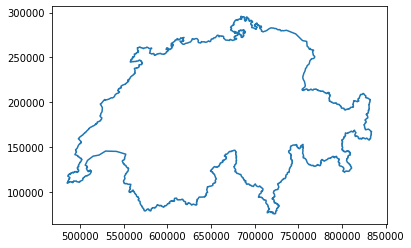

In [4]:
#Print the country's contours

shape=sf.shapeRecords()[7]
x = [i[0] for i in shape.shape.points[:]]
y = [i[1] for i in shape.shape.points[:]]
plt.plot(x[0:-175], y[0:-175])

In [5]:
#Load data with region attributes and put it into a dataframe
shp_path = 'swiss_shp/swissTLMRegio_HOHEITSGEBIET_LV03.shp'
sf = shp.Reader(shp_path, encoding='windows-1252')
fields = [x[0] for x in sf.fields][1:]
records = sf.records()
shps = [s.points for s in sf.shapes()]
df = pd.DataFrame(columns=fields, data=records)
df = df.assign(coords=shps)
df.head(5)

,OBJECTID,UUID,DATUM_AEND,DATUM_ERST,HERKUNFT,HERKUNFT_J,OBJEKTART,BFS_NUMMER,BEZIRKSNUM,KANTONSNUM,NAME,GEM_TEIL,GEM_FLAECH,SEE_FLAECH,ICC,SHN,EINWOHNERZ,coords
0,8907,80BDC838-B025-4860-B319-3C87EF5B26C2,2019-09-24,2016-01-18,EBM,2018,Gemeindegebiet,0,AT70200,AT70000,Sölden,0,-29999.0,-29998.0,AT,AT70220,3124,"[(883434.7562500015, 208358.54250000045), (883..."
1,8908,FE2E874F-B9B8-4714-96CF-5F8AA5DF451E,2019-12-04,2009-03-25,TLM,2019,Gemeindegebiet,3762,CH18430000,CH18000000,Scuol,0,43861.0,-29998.0,CH,CH18433762,4638,"[(812980.4475000016, 194958.07375000045), (813..."
2,8909,3FA8610C-EB98-4DBA-8A62-D22D739D6032,2019-12-04,2011-04-12,TLM,2019,Gemeindegebiet,1631,N/A,CH08000000,Glarus Süd,0,43003.0,-29998.0,CH,CH08001631,9575,"[(730976.0, 192852.0), (730702.0, 192726.0), (..."
3,8910,9CCECBE8-D621-4DF5-BB7B-409F9BF06A46,2019-12-04,2009-03-25,TLM,2019,Gemeindegebiet,3746,CH18430000,CH18000000,Zernez,0,34404.0,-29998.0,CH,CH18433746,1540,"[(802701.8987499997, 192061.9750000015), (8027..."
4,8911,43CB4FD5-59A4-469E-824D-4E6D9A9172FE,2019-12-04,2016-01-21,TLM,2019,Gemeindegebiet,3543,CH18410000,CH18000000,Surses,0,32377.0,-29998.0,CH,CH18413543,2356,"[(775675.0, 153305.0), (775346.0, 152390.0), (..."


In [30]:
#Create pandas dataframe with lakes coordinates
lac_data=[]
for i in range(0, len(df)):
    #print(df.loc[i, 'GEM_TEIL']==str(0))
    #if df.loc[i, 'GEM_TEIL']==str(1):
    if int(df.loc[i, 'EINWOHNERZ'])<0 and df.loc[i, 'ICC']=='CH':
        #print(df.loc[i, 'NAME'])
        #print(df.loc[i, 'EINWOHNERZ'])
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']])
    elif 'Lac Léman' in df.loc[i, 'NAME'] and df.loc[i, 'ICC']!='CH':
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']]) #Add french part of the lake of Geneva 
    elif 'Bodensee' in df.loc[i, 'NAME'] and df.loc[i, 'ICC']!='CH':
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']]) #Add German and Austrian part of Bodensee
    elif 'Lago Maggiore' in df.loc[i, 'NAME'] and df.loc[i, 'ICC']!='CH':
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']]) #Add Italian part of Lago Maggiore
    elif 'Lago di Lugano' in df.loc[i, 'NAME'] and df.loc[i, 'ICC']!='CH':
        lac_data.append([df.loc[i, 'NAME'], df.loc[i, 'coords']]) #Add Italian part of Lago Maggiore
lac_data_df=pd.DataFrame(lac_data, columns=['name', 'coordinates'])

In [32]:
lac_data_df.head()

,name,coordinates
0,Lac Léman (VD),"[(550845.0, 146825.0), (550885.0, 146793.0), (..."
1,Lac Léman,"[(509983.7424999997, 132354.8049999997), (5099..."
2,Bodensee,"[(725119.7087499984, 291581.32250000164), (724..."
3,Bodensee (TG),"[(737243.0, 276382.0), (737045.0, 276475.0), (..."
4,Lago Maggiore,"[(697692.0975000001, 97740.61874999851), (6979..."


In [237]:
#Create pandas dataframe with region coordinates and population

commune_data=[]

for i in range(0, len(df)):
    if int(df.loc[i, 'EINWOHNERZ'])>0 and df.loc[i, 'ICC']=='CH': #exclude data on lakes and outside of the country
        surface_area=round(int(df.iloc[i, 12])/100, 2) # convert from hectare to sqr km
        pop_density=round(int(df.loc[i, 'EINWOHNERZ'])/surface_area, 3)
        if pop_density<0:
            pop_density=0
        commune_data.append([df.loc[i, 'NAME'], df.loc[i, 'EINWOHNERZ'], str(surface_area), pop_density, df.loc[i, 'coords']])
        
    population_data=pd.DataFrame(commune_data, columns=['name', 'pop', 'surface', 'density', 'coordinates'])
population_data.head()

,name,pop,surface,density,coordinates
0,Scuol,4638,438.61,10.574,"[(812980.4475000016, 194958.07375000045), (813..."
1,Glarus Süd,9575,430.03,22.266,"[(730976.0, 192852.0), (730702.0, 192726.0), (..."
2,Zernez,1540,344.04,4.476,"[(802701.8987499997, 192061.9750000015), (8027..."
3,Surses,2356,323.77,7.277,"[(775675.0, 153305.0), (775346.0, 152390.0), (..."
4,Bagnes,8073,284.1,28.416,"[(599458.0, 93275.0), (599363.0, 92955.0), (59..."


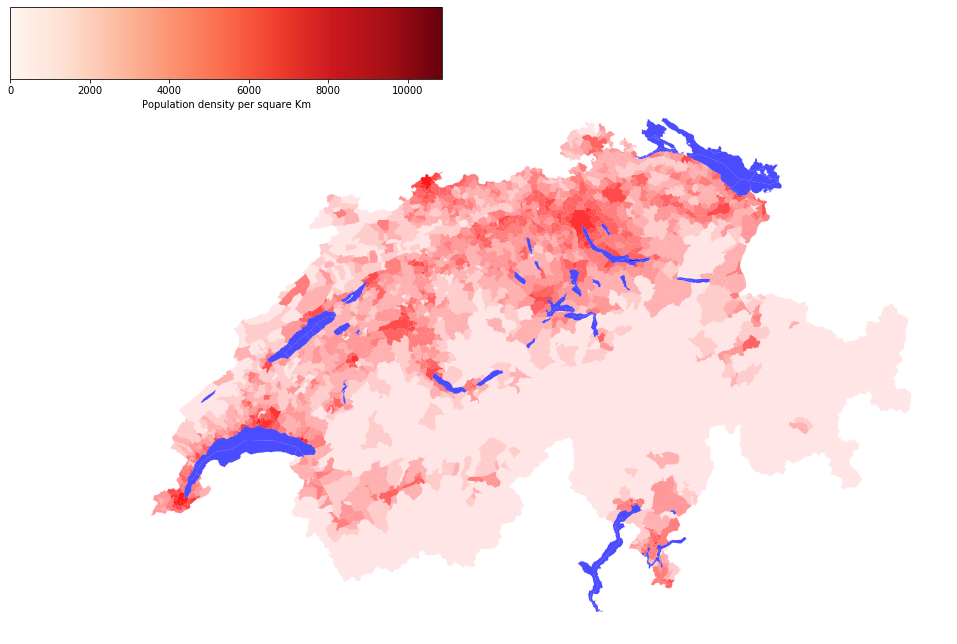

In [226]:
#Plot results on a map

fig=plt.figure(figsize = (15, 10))
num_tot=[]
for i in range(0, len(population_data)):
    num=float(population_data.iloc[i, 3])
    num_tot.append(num)
    if 0<= num <=50:
        alpha1=0.1
    elif 50< num <=100:
        alpha1=0.2 
    elif  100< num <=200:
        alpha1=0.3
    elif  200< num <=400:
        alpha1=0.4
    elif  400< num <=800:
        alpha1=0.5
    elif  800< num <=1600:
        alpha1=0.6
    elif  1600< num <=3200:
        alpha1=0.7
    elif  3200< num <=6400:
        alpha1=0.8    
    else:
        alpha1=0.9
        
    coordinate_xy=population_data.iloc[i, 4]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'r', alpha=alpha1)

for i in range(0, len(lac_data_df)):
    coordinate_xy=lac_data_df.iloc[i, 1]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'b', alpha=0.7)
    plt.grid(False)
    plt.axis('off')

ax1 = fig.add_axes([0.03, 0.90, 0.4, 0.1])

cmap = mpl.cm.Reds
norm = mpl.colors.Normalize(vmin=min_density, vmax=max_density)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')

cb1.set_label('Population density per square Km')



plt.savefig('swiss_map.png')

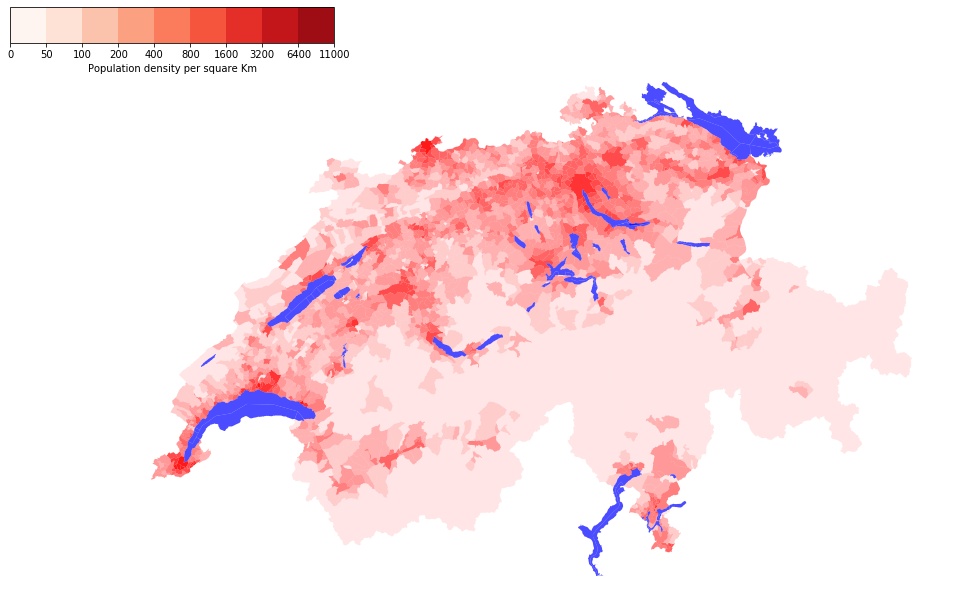

In [344]:




fig=plt.figure(figsize = (15, 10))
num_tot=[]
bounds=[0, 50, 100, 200, 400, 800, 1600, 3200, 6400, 11000]
alphas=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in range(0, len(population_data)):
    num=float(population_data.iloc[i, 3])
    num_tot.append(num)
    if 0<= num <=50:
        alpha1=0.1
    elif 50< num <=100:
        alpha1=0.2 
    elif  100< num <=200:
        alpha1=0.3
    elif  200< num <=400:
        alpha1=0.4
    elif  400< num <=800:
        alpha1=0.5
    elif  800< num <=1600:
        alpha1=0.6
    elif  1600< num <=3200:
        alpha1=0.7
    elif  3200< num <=6400:
        alpha1=0.8    
    else:
        alpha1=0.9
    #for i in range(1, len(bounds)-1):
    #    if bounds[i-1]<=num <= bounds[i]:
    #        alpha1=alphas[i]
    #        break
    #    alpha1=alphas[-1]
        
    coordinate_xy=population_data.iloc[i, 4]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'r', alpha=alpha1)

for i in range(0, len(lac_data_df)):
    coordinate_xy=lac_data_df.iloc[i, 1]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'b', alpha=0.7)
    plt.grid(False)
    plt.axis('off')


ax1 = fig.add_axes([0.03, 0.90, 0.3, 0.05])
    
col_map = cm.get_cmap('Reds', 10)
newcolors = col_map(np.linspace(0, 1, 10))
newcolors = newcolors[0:9, :]
col_map = ListedColormap(newcolors)
norm = mpl.colors.BoundaryNorm(bounds, col_map.N)
cb3 = mpl.colorbar.ColorbarBase(ax1, cmap=col_map,
                                norm=norm,
                                spacing='uniform',
                                orientation='horizontal')
cb3.set_label('Population density per square Km')
plt.savefig('swiss_map.png')
plt.show()


#plt.savefig('swiss_map.png')

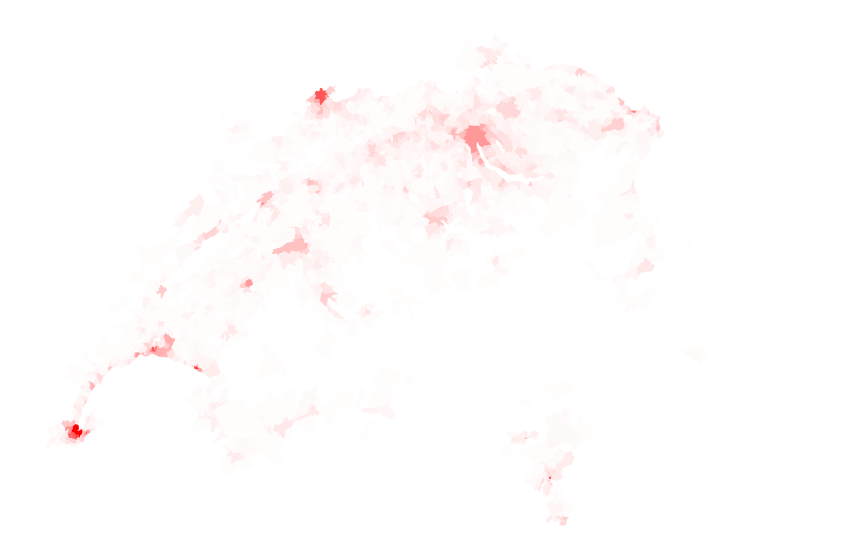

In [303]:
#Test continuous alpha 
population_density=population_data['density'].values

plt.figure(figsize = (15, 10))
plt.grid('off')
for i in range(0, len(population_data)):
    num=float(population_data.iloc[i, 3])
    alpha2=round(population_data.iloc[i, 3]/np.max(population_density), 2)   
    coordinate_xy=population_data.iloc[i, 4]
    x = [i[0] for i in coordinate_xy]
    y = [i[1] for i in coordinate_xy]
    plt.fill(x, y, 'r', alpha=alpha2)

plt.grid(False)
plt.axis('off')

plt.savefig('swiss_map3.png')

# Create DOT MAP:
#
#

each point represent 1000 people
#

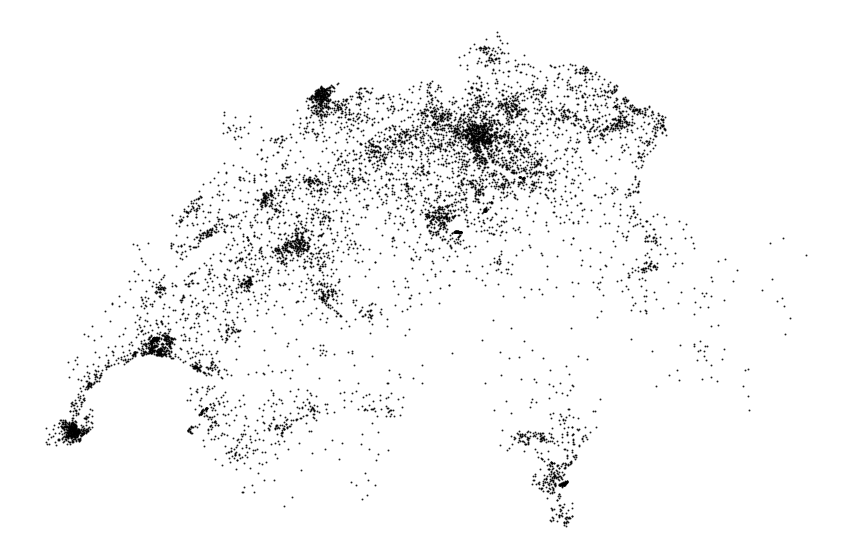

In [308]:

#First let's define function for random point generation inside the polygone of every formation.

def random_point_in_shape(polygone, num_points):
    i=0
    j=0
    seed = None
    min_x, min_y, max_x, max_y = polygone.bounds
    lst_points=np.zeros((num_points, 2), dtype=float)
    while j < num_points:
        s=RandomState(seed+i) if seed else RandomState(seed)
        random_point = Point([s.uniform(min_x, max_x), s.uniform(min_y, max_y)])
        if random_point.within(polygone):
            lst_points[j, :]=np.array(random_point)
            j=j+1
        i+=1
    return lst_points



#2 Create the plot
fig=plt.figure(figsize = (15, 10))
for i in range(0, len(population_data)):

    pop_in_area=population_data.iloc[i, 1]
    
    pop_adj=int(round(pop_in_area/1000))
    alpha1=0.75
    
    coordinate_xy=population_data.iloc[i, 4]
    p1 = Polygon(np.array(coordinate_xy))
    g2 = gpd.GeoSeries(p1)
    
    lst_points=random_point_in_shape(p1, pop_adj)
    plt.scatter(lst_points[:, 0], lst_points[:, 1], c='k', s=1, alpha=alpha1)
    
plt.axis('off')
plt.savefig('swiss_dot_map.png')
plt.show()

In [ ]:
shp_path = 'swiss_shp/swissTLMRegio_LANDESGEBIET_LV03.shp'
sf = shp.Reader(shp_path, encoding='windows-1252')
shape=sf.shapeRecords()[7]
x = [i[0] for i in shape.shape.points[:]]
y = [i[1] for i in shape.shape.points[:]]
plt.plot(x[0:-175], y[0:-175])